# Introduction to Particle Filtering

Particle filtering (also known as the Sequential Monte Carlo method) is a powerful technique used in state estimation for nonlinear and non-Gaussian dynamic systems. It's particularly useful when you need to estimate the state of a system over time using noisy and indirect observations.

It can be seen as a "brute-force" way to estimate the system state, based on running many parallel simulations.

## **Why is the Particle Filter Called a "Filter"?**

The **particle filter** is called a **filter** because it is used to estimate the hidden (latent) state of a **dynamic system** over time, given noisy observations. The term "filtering" comes from **Bayesian filtering**, which refers to the process of continuously updating our belief about the system's state as new measurements arrive.

### **Formulating the Filtering Problem**
The **goal** of filtering is to estimate the **hidden state** $ x_t $ of a system at time $ t $, given a sequence of noisy observations $ z_{1:t} $. 

A filtering problem is typically formulated using a **state-space model** consisting of:

1. **State Transition Model** (How the system evolves):  
   $$
   x_t = f(x_{t-1}, v_t)
   $$
   - $ x_t $ is the state at time $ t $.
   - $ f(\cdot) $ is the transition function (possibly nonlinear).
   - $ v_t $ is the **process noise**.

2. **Observation Model** (How we observe the system):  
   $$
   z_t = h(x_t, w_t)
   $$
   - $ z_t $ is the measurement at time $ t $.
   - $ h(\cdot) $ is the observation function (possibly nonlinear).
   - $ w_t $ is the **measurement noise**.

Given the sequence of measurements $ z_{1:t} $, we aim to compute the **posterior distribution** of the state $ x_t $:

$$
p(x_t \mid z_{1:t})
$$

### **How the Particle Filter Solves This**
The particle filter **approximates** the distribution $ p(x_t \mid z_{1:t}) $ using a set of weighted samples (particles), instead of using an analytical solution (which may be intractable).

- Instead of storing a probability distribution, we use **particles** $ \{x_t^i\} $ with **weights** $ w_t^i $.
- The filtering process involves:
  - **Propagating** particles using the transition model.
  - **Reweighting** particles using the likelihood of observations.
  - **Resampling** to discard unlikely particles and focus on probable ones.

## Why Use Particle Filtering?
- When systems are nonlinear, traditional methods like the **Kalman filter** (which assumes linearity) don't work well.
- When noise is non-Gaussian, the **Extended Kalman Filter (EKF)** and **Unscented Kalman Filter (UKF)** may not perform well.
- Particle filtering can handle arbitrary distributions and complex system models.
- Easy to incorporate extra knowledge of the system process.

## Downsides of Particle Filtering

- It's a brute-force technique: more accuracy requires more computational power.
- Analysis is complex. If you need to provide guarantees, you need a bachelor in statistics or something to that effect.

## How Does It Work?

The main idea is to represent the probability distribution of a system's state using a **set of particles** (samples). These particles approximate the **posterior distribution** of the state given the observations. We use the model of the system dynamics to oudpate each particle, and do a selection of the particles that are performing best according to the observations we get from the system.

## Steps in a Particle Filter:

### 1. **Initialization:** 
    - Generate $ N $ particles, each representing a possible system state.
    - Assign each particle an initial weight (often uniform, but if you have knowledge of the state, use it here).

In [94]:
import numpy as np
import matplotlib.pyplot as plt

# Number of particles
N = 5

# True state (we don't know this in real applications)
true_position = 0
true_velocity = 1  # Constant velocity

# Initialize particles
particles = np.random.uniform(-1, 1, N)  # Random positions
weights = np.ones(N) / N  # Uniform weights

# Print particles and weights
print('Particles:', particles)
print('Weights:', weights)


Particles: [-0.37336111 -0.44406079  0.26985023  0.42068342 -0.85024061]
Weights: [0.2 0.2 0.2 0.2 0.2]


### 2. **Prediction (Propagation):**
- Evolve each particle using the **state transition model**.
- This step incorporates process noise and observation noise.

In [95]:
# Noise standard deviations
motion_noise_std = 0.1

# Move true object
true_position += true_velocity + np.random.randn() * motion_noise_std  # True motion

print('True position:', true_position)

True position: 1.1296688401324357


In [96]:
# Predict (Move particles according to motion model)
particles += true_velocity + np.random.randn(N) * motion_noise_std
particles

array([0.51754326, 0.55975467, 1.17592746, 1.35157945, 0.13061185])

Compare the position of each particle with the true position above and note that some particles are closer to the real position than others.

### 3. **Update (Weighting):**
- Compute the likelihood of each particle given the new observation.
- Reweight the particles based on how well they match the observation.
   -  The idea is that particles that have been "luckier" in guessing the observation value are given more weight. We could simply define the weights based on the differences between the particle positions and the observation, but this poses several issues: it neglects the standard deviations of the observation standard deviation (intuitively, larger standard deviation of the noise should make it less significant that particles end up further away from the observation); negative differences count the same as positive differences. So we use a smarter update equation below. 

In [97]:
# Observation noise standard deviation
observation_noise_std = 0.1

# Obtain noisy observation
observation = true_position + np.random.randn() * observation_noise_std
print('Observation data of the true position', observation) # This matches something obtained from a sensor, for example

Observation data of the true position 0.9512437510148035


In [98]:
# Update weights based on observation likelihood
weights = np.exp(-0.5 * ((particles - observation) / observation_noise_std) ** 2)
weights += 1e-300  # Avoid zero weights, just for numerical stability
weights /= np.sum(weights)  # Normalize: turn the weights into a probability distribution

weights

array([1.01625765e-03, 5.79936024e-03, 9.89098658e-01, 4.08572421e-03,
       2.93742321e-14])

Note how some weights are higher than others, reflecting the best particles above:

In [99]:
# Get the index of the particle with the highest weight
max_weight_index = np.argmax(weights)
print(f'Particle with index {max_weight_index} has the highest weight estimating the position at: ', particles[max_weight_index])
print('Observation:', observation)
print('True position:', true_position)


Particle with index 2 has the highest weight estimating the position at:  1.175927457973907
Observation: 0.9512437510148035
True position: 1.1296688401324357


Let's break down the update code above:

   1. **Difference between particles and observation:**  
      $$
      (particles - observation)
      $$
      This computes how far each particle's position is from the observed position.

   2. **Standardize by the noise standard deviation:**  
      $$
      \frac{(particles - observation)}{\text{observation\_noise\_std}}
      $$
      This step normalizes the difference so that it is expressed in terms of the noise scale. If the noise is large, small differences are less significant.

   3. **Square the result:**  
      $$
      \left( \frac{(particles - observation)}{\text{observation\_noise\_std}} \right)^2
      $$
      Squaring ensures that differences in both directions (above or below the observed value) contribute positively.

   4. **Multiply by -0.5:**  
      $$
      -0.5 \times \left( \frac{(particles - observation)}{\text{observation\_noise\_std}} \right)^2
      $$
      This is part of the **Gaussian function**, which follows the form:
      $$
      \exp\left( -\frac{(x - \mu)^2}{2\sigma^2} \right)
      $$
      Here, $\mu = \text{observation}$ and $\sigma = \text{observation\_noise\_std}$.

   5. **Apply the exponential function:**  
      ```python
      np.exp(...)
      ```
      This converts the squared difference into a likelihood score. **Particles closer to the observation get a higher weight, while those further away get a lower weight.**

   6. **Normalization**:
      After computing the weights, we normalize them so they sum to 1:
      ```python
      weights /= np.sum(weights)
      ```
      This ensures they can be used as **probabilities** in the resampling step.


   **Why Use This Formula?**
   - It ensures that **particles near the observation are given higher weights**.
   - It models **Gaussian measurement noise**, meaning our observations are assumed to follow a normal distribution around the true value.
   - The function **preserves relative probabilities**, so when we normalize later, the most probable particles contribute more.


### 4. **Resampling:**
   - Particles with high weights are duplicated.
   - Particles with low weights are discarded.
   - This step prevents particle **degeneracy** (where a few particles dominate).

In [100]:
# Select particles that remain. We're drawing N samples of the random choice function that selects at random indexes of particles (0...N), but since we're passing the probability distribution of each choice, the particles with higher weights will be selected more often.
indices = np.random.choice(np.arange(N), size=N, p=weights)
print("N particles that will remain: ", indices)

N particles that will remain:  [2 2 2 2 2]


In [101]:
print('Particles before selection:', particles)
particles = particles[indices]
print('Particles after selection:', particles)

Particles before selection: [0.51754326 0.55975467 1.17592746 1.35157945 0.13061185]
Particles after selection: [1.17592746 1.17592746 1.17592746 1.17592746 1.17592746]


### 5. **Repeat:** 
- Store the estimated system state (mean of selected particles).
- Reset the weights, and 
- repeat the above steps, as each new observation of the system arrives.

In [102]:
weights = np.ones(N) / N  # Reset weights so every particle is now equally likely
print('Weights:', weights)

Weights: [0.2 0.2 0.2 0.2 0.2]


In [103]:
# Store estimated position (mean of particles)
estimated_position = np.mean(particles)
print('Estimated position:', estimated_position)
# Get standard deviation of particles. Good to give a notion of uncertainty.
std = np.std(particles)
print('Standard deviation:', std)

Estimated position: 1.175927457973907
Standard deviation: 0.0


## Putting it all together

The following code puts the above calculation together in a practical example.

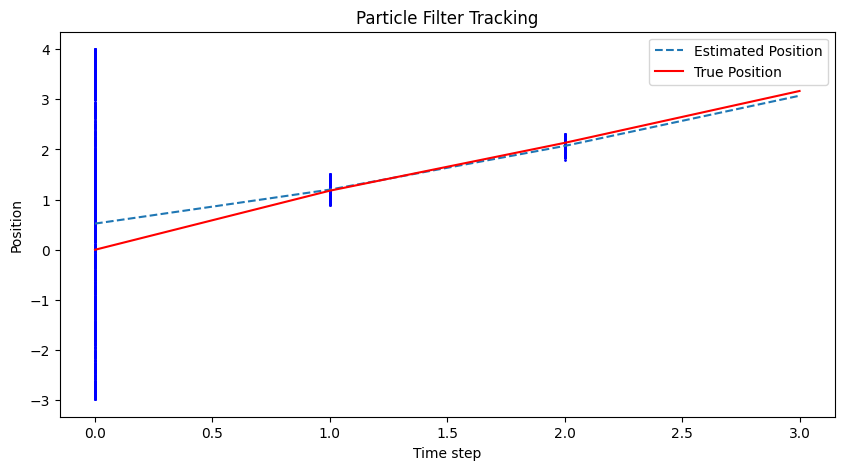

In [104]:
# Number of particles
N = 1000

# True state (we don't know this in real applications)
true_position = 0
true_velocity = 1  # Constant velocity

# Noise standard deviations
motion_noise_std = 0.1
observation_noise_std = 0.1

# Initialize particles
particles = np.random.uniform(-3, 4, N)  # Random positions. Change to try out different initializations
weights = np.ones(N) / N  # Uniform weights

# Simulation parameters
num_steps = 3  # Time steps

# Store results
positions = [np.mean(particles)]  # Store estimated positions
true_positions = [true_position]  # Store true positions
particle_positions = [np.copy(particles)]  # Store particle positions

# Particle Filter Loop
for t in range(num_steps):
    # Move true object
    true_position += true_velocity + np.random.randn() * motion_noise_std  # True motion
    true_positions.append(true_position)

    # Simulate noisy observation
    observation = true_position + np.random.randn() * observation_noise_std
    
    # 1. Predict (Move particles according to motion model)
    particles += true_velocity + np.random.randn(N) * motion_noise_std
    
    # 2. Update weights based on observation likelihood
    weights = np.exp(-0.5 * ((particles - observation) / observation_noise_std) ** 2)
    weights += 1e-300  # Avoid zero weights
    weights /= np.sum(weights)  # Normalize
    
    # 3. Resample: Select particles based on their weights
    indices = np.random.choice(np.arange(N), size=N, p=weights)
    particles = particles[indices]
    weights = np.ones(N) / N  # Reset weights
    
    assert len(particles) == N

    # Store particle positions
    particle_positions.append(np.copy(particles))

    # Store estimated position (mean of particles)
    estimated_position = np.mean(particles)
    positions.append(estimated_position)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(range(num_steps+1), positions, label="Estimated Position", linestyle="dashed")
plt.plot(range(num_steps+1), true_positions, label="True Position", color='r')

# Plot particles
for t in range(num_steps):
    plt.scatter([t] * N, particle_positions[t], color='b', s=1)
    
plt.xlabel("Time step")
plt.ylabel("Position")
plt.legend()
plt.title("Particle Filter Tracking")
plt.show()